# House Prices - Advanced Regression Techniques
## Exploratory Data Analysis
## Trevor Johnson

<br>

### Goal:
Predict sales price for each house (`SalePrice`). RMSE on log(pred) - log(actual) will be the evaluation metric. Final submission dataset should contain only the two fields `ID` and `SalePrice`. 

## Setups

In [25]:
# libraries
import pandas as pd 
import numpy as np 
import os 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# set directory and read in the data
os.chdir("/Users/tj/Desktop/data/housing")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
sample = pd.read_csv("sample_submission.csv")

## Initial Exploration

Check for missing values. Some variables have mostly missing values

In [13]:
train.isnull().sum()[train.isnull().sum() != 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

## Data Visualization

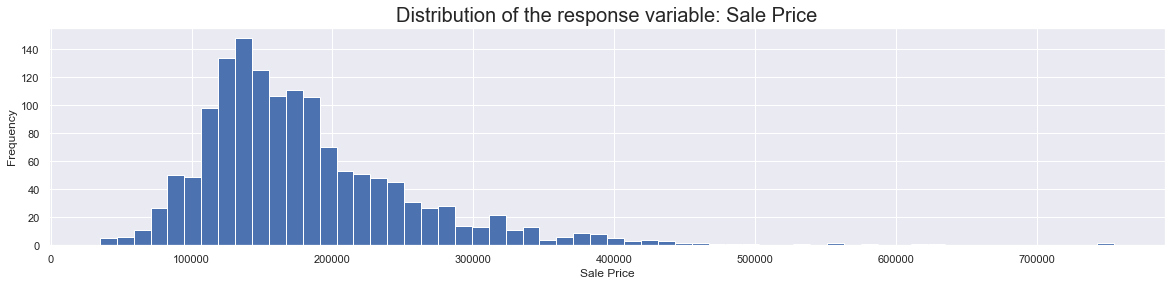

In [130]:
# distribution of response variable
fig, ax = plt.subplots(figsize = (20, 4))
ax.hist(train.SalePrice, bins = 60)
ax.set_xlabel("Sale Price")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of the response variable: Sale Price", size=20)
print("")

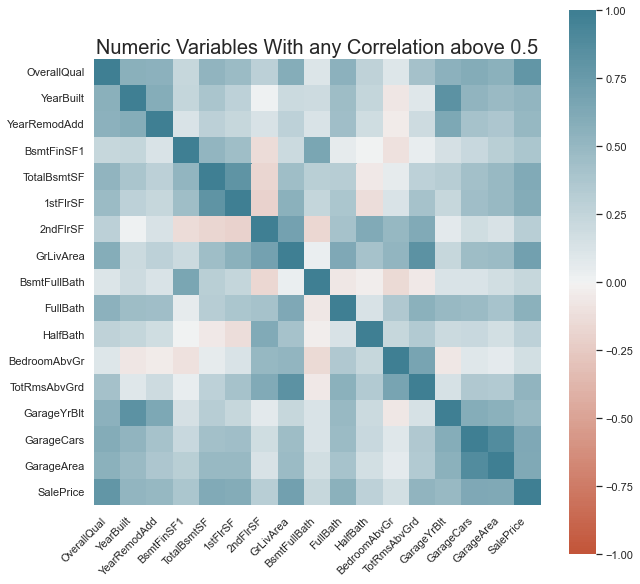

In [58]:
# get correlations of all numeric vars
corr_orig = train.loc[:, (train.dtypes == type(1.0)) | (train.dtypes == type(1))].corr()

# there are 38 of them, let's look at a subset to only show the ones w/ correlations above .5
threshold = .5
bool_list = [sum((corr_orig.iloc[i,:] < 1) & (corr_orig.iloc[i,:] > threshold)) > 0 for i in range(corr_orig.shape[0])]
corr = train.loc[:, (train.dtypes == type(1.0)) | (train.dtypes == type(1))].loc[:, bool_list].corr()

# plot the results
sns.set()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title("Numeric Variables With any Correlation above {:.1f}".format(threshold), fontdict = {"fontsize": 20})

plt.gcf().set_size_inches(10, 10)
print("")

In [121]:
# scatter plots of all num vars w/ response var
num_vars = train.loc[:, (train.dtypes == type(1.0)) | (train.dtypes == type(1))]
num_vars.shape

# plot the first 20
num_rows = 4
num_cols = 5
fig, ax = plt.subplots(num_rows, num_cols, figsize = (20, 10))

col_i = 0
for i in range(num_rows):
    for j in range(num_cols):
        ax[i][j].scatter()


# now plot the remaining 17

(1460, 38)

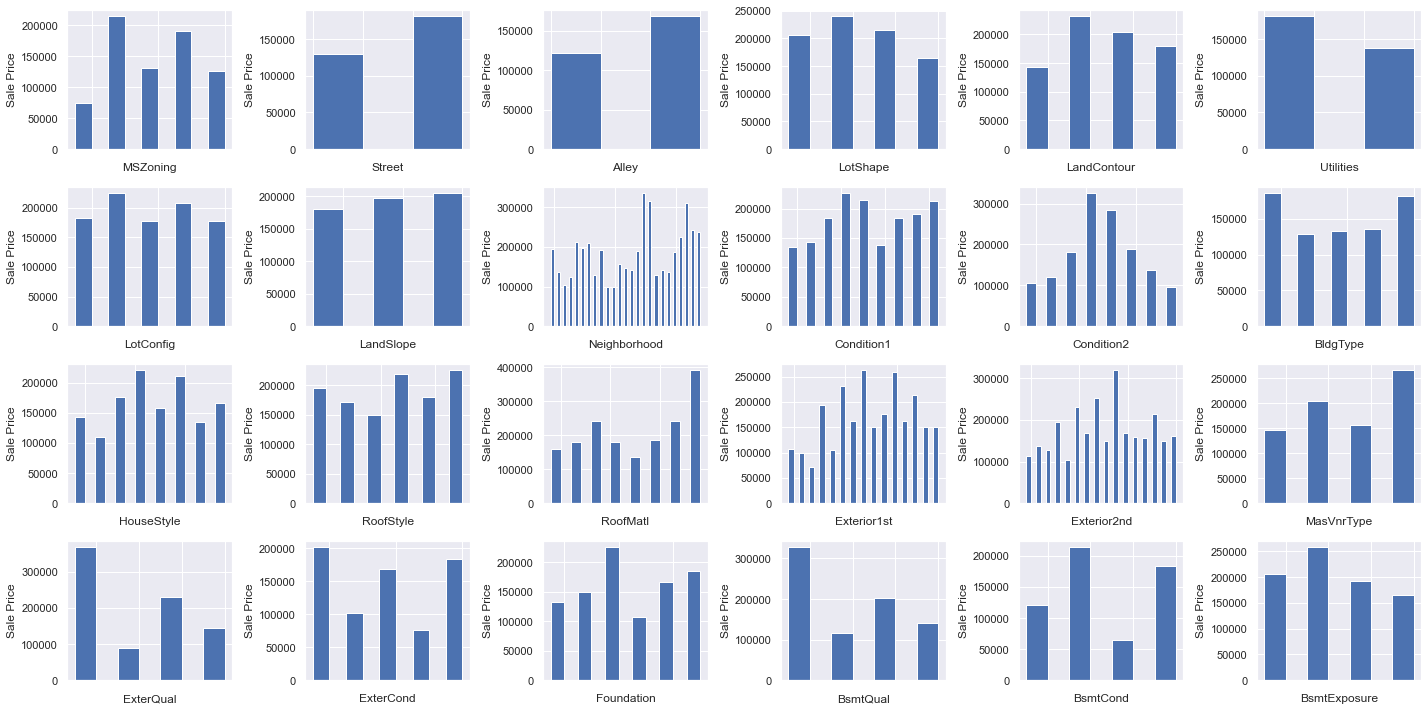

In [112]:
# categorical exploration
cat_vars = pd.concat([train.loc[:, train.dtypes == type(train.dtypes[2])], train.SalePrice], axis = 1)
n_cols = cat_vars.shape[1]

# plots
num_row = 4
num_col = 6
fig, ax = plt.subplots(num_row, num_col, figsize = (20, 10))

count_k = 0
for i in range(num_row):
    for j in range(num_col):

        # each df
        var_i = cat_vars.columns[count_k]

        df_i = pd.DataFrame(cat_vars.groupby(var_i)['SalePrice'].mean())
        df_i.reset_index(inplace = True)

        # create plot i
        x = np.arange(df_i.shape[0])
        width = .5

        # set the bars
        ax[i][j].bar(x - width / 2, df_i.SalePrice, width, label = "x")
        ax[i][j].set_xlabel(var_i)
        ax[i][j].set_ylabel("Sale Price")
        #ax[i][j].set_xticklabels(df_i[var_i], rotation = 90)
        ax[i][j].set_xticklabels("")
        
        count_k += 1


fig.tight_layout()

print("")


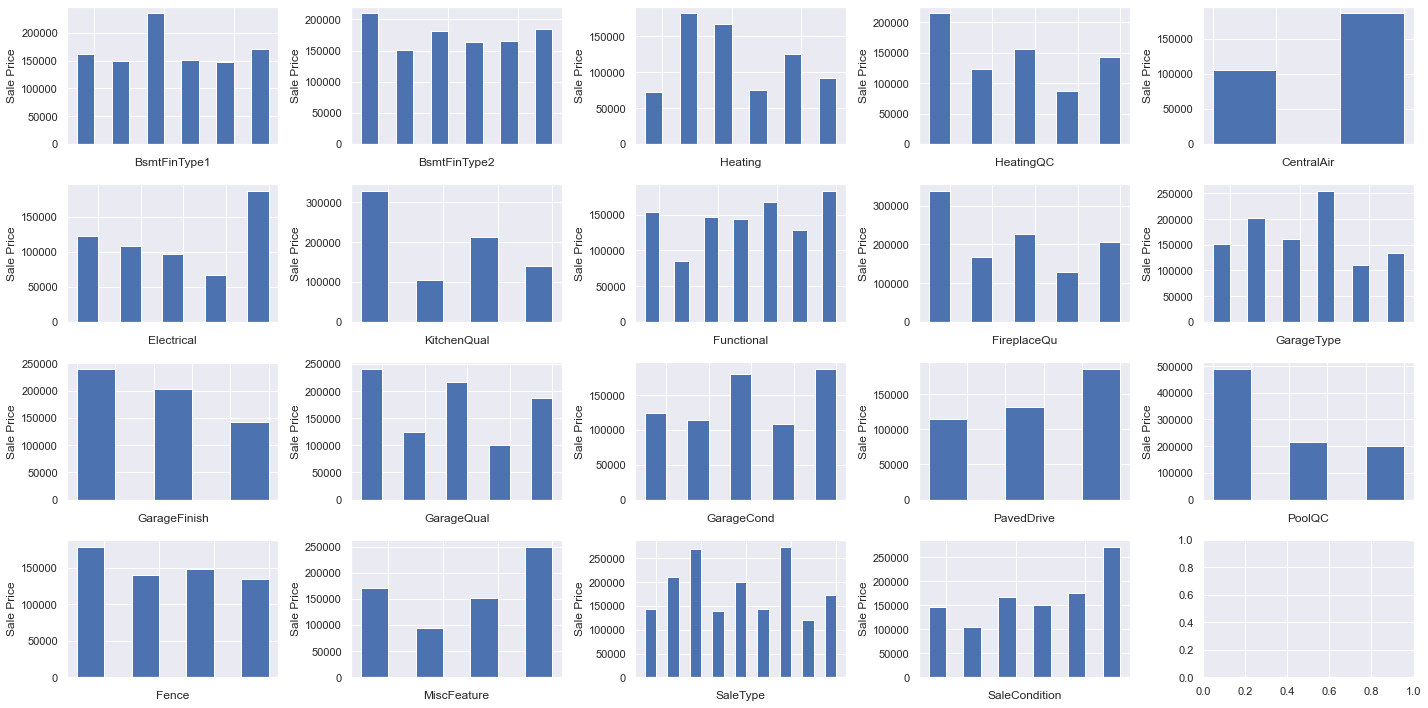

In [119]:
# 2nd set of categorical vars
cat_vars2 = cat_vars.iloc[:, 4*6:]

# plots
num_row = 4
num_col = 5
fig, ax = plt.subplots(num_row, num_col, figsize = (20, 10))

count_k = 0
for i in range(num_row):
    for j in range(num_col):

        # each df
        var_i = cat_vars2.columns[count_k]

        if var_i == "SalePrice":

            pass 

        else:

            df_i = pd.DataFrame(cat_vars2.groupby(var_i)['SalePrice'].mean())
            df_i.reset_index(inplace = True)

            # create plot i
            x = np.arange(df_i.shape[0])
            width = .5

            # set the bars
            ax[i][j].bar(x - width / 2, df_i.SalePrice, width, label = "x")
            ax[i][j].set_xlabel(var_i)
            ax[i][j].set_ylabel("Sale Price")
            #ax[i][j].set_xticklabels(df_i[var_i], rotation = 90)
            ax[i][j].set_xticklabels("")
            
            count_k += 1


fig.tight_layout()

print("")

## Modeling

In [ ]:
# start w/ lasso regression to narrow down the variable list

In [ ]:
# Now w/ narrowed down variable list, build a glm w/ gamma family due to sale price dist shape

In [131]:
# random forest

In [132]:
# boosted tree

In [133]:
# neural net??

In [134]:
# any other model?

## Best Model